In [151]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 

# 애플코딕 설치되어 있을때
plt.rcParams['font.family'] = 'AppleGothic'

## 법정동중심 및 충전소간 거리 전처리

- 법정동 중심점 좌표 구하기

In [152]:
import geopandas as gpd

In [154]:
# 서울시 법정동 경계 데이터 불러오기
dong_boundary = gpd.read_file('/Users/sookyeong/Documents/내배캠/팀프로젝트/project5_final/emd.shp', encoding='cp949')

# CRS 설정
dong_boundary.crs = 'EPSG:5179'  

# 중심점 좌표 계산
dong_boundary['center_point'] = dong_boundary['geometry'].centroid

# 좌표를 WGS 84 좌표계로 변환
dong_boundary['geometry'] = dong_boundary['geometry'].to_crs(epsg=4326)
dong_boundary['center_point'] = dong_boundary['center_point'].to_crs(epsg=4326)


In [155]:
#위도, 경도 컬럼 생성
dong_boundary['중심위도'] = dong_boundary['center_point'].y
dong_boundary['중심경도'] = dong_boundary['center_point'].x

# 병합하기 위해 컬럼명 변경
dong_boundary = dong_boundary.rename(columns = {'EMD_CD' : '법정동코드', 'EMD_KOR_NM':'법정동명'})

#필요한 컬럼 남기기
dong_boundary = dong_boundary.drop(columns = ['geometry', 'center_point', 'EMD_ENG_NM'])

In [156]:
dong_boundary

,법정동코드,법정동명,중심위도,중심경도
0,11110101,청운동,37.589205,126.969324
1,11110102,신교동,37.584506,126.967942
2,11110103,궁정동,37.584698,126.972706
3,11110104,효자동,37.582668,126.971953
4,11110105,창성동,37.580560,126.972474
...,...,...,...,...
5060,51830310,서면,38.010905,128.525070
5061,51830320,손양면,38.047376,128.652336
5062,51830330,현북면,37.950280,128.646106
5063,51830340,현남면,37.938963,128.738447


- 충전소별 법정동 중심좌표와의 거리

In [157]:
charger_df = pd.read_csv('/Users/sookyeong/Documents/내배캠/팀프로젝트/project5_final/MillionVolt/전처리_충전소.csv')
charger_df.head(3) 

/var/folders/tz/h0d7hy211kj12my58s3b3m7m0000gn/T/ipykernel_5005/2199635762.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  charger_df = pd.read_csv('/Users/sookyeong/Documents/내배캠/팀프로젝트/project5_final/MillionVolt/전처리_충전소.csv')


,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),운영기관(소),급속충전량,충전기타입,이용자제한,충전기ID,충전소ID,위도,경도,법정동코드,법정동명
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174003,37.552909,127.137255,1174010700,암사동
1,2017,서울특별시,강동구,서울특별시 강동구 선사로 70,천호유수지 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174004,37.544812,127.121840,1174010900,천호동
2,2017,서울특별시,강동구,서울특별시 강동구 진황도로29길 34,천호3동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,환경부(협회),급속(50kW),DC차데모+AC3상+DC콤보,이용가능,1,ME174005,37.538795,127.133399,1174010900,천호동


In [158]:
charger_df['법정동코드'] = charger_df['법정동코드'].astype(str).str[:8]
charger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45365 entries, 0 to 45364
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   설치년도     45365 non-null  int64  
 1   시도       45365 non-null  object 
 2   군구       45365 non-null  object 
 3   주소       45365 non-null  object 
 4   충전소명     45365 non-null  object 
 5   시설구분(대)  45365 non-null  object 
 6   시설구분(소)  45365 non-null  object 
 7   기종(대)    45365 non-null  object 
 8   기종(소)    45365 non-null  object 
 9   운영기관(대)  45365 non-null  object 
 10  운영기관(소)  45365 non-null  object 
 11  급속충전량    348 non-null    object 
 12  충전기타입    45365 non-null  object 
 13  이용자제한    45365 non-null  object 
 14  충전기ID    45365 non-null  int64  
 15  충전소ID    45365 non-null  object 
 16  위도       45365 non-null  float64
 17  경도       45365 non-null  float64
 18  법정동코드    45365 non-null  object 
 19  법정동명     45365 non-null  object 
dtypes: float64(2), int64(2), object(16)
memory usage: 

In [159]:
# 법정동 중심좌표 데이터프레임과 합치기
charger_dong_df = pd.merge(charger_df, dong_boundary, on = '법정동코드', how = 'left')


In [160]:
#컬럼정리
charger_dong_df.head(3) 
charger_dong_df = charger_dong_df.drop(columns = '법정동명_y')
charger_dong_df = charger_dong_df.rename(columns = {'법정동명_x' :'법정동명'})
display(charger_dong_df.head(3) )
charger_dong_df.isna().sum()

In [162]:
import geopy.distance

# 각 충전소와 법정동 중심 간의 최단 거리 계산하여 '충전소중심지거리' 열에 저장
charger_dong_df['충전소중심지거리'] = charger_dong_df.apply(lambda row: geopy.distance.distance((row['위도'], row['경도']), (row['중심위도'], row['중심경도'])).m, axis=1)


In [163]:
charger_dong_df.head(3)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,이용자제한,충전기ID,충전소ID,위도,경도,법정동코드,법정동명,중심위도,중심경도,충전소중심지거리
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,이용가능,1,ME174003,37.552909,127.137255,11740107,암사동,37.557805,127.131062,771.170334
1,2017,서울특별시,강동구,서울특별시 강동구 선사로 70,천호유수지 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,이용가능,1,ME174004,37.544812,127.121840,11740109,천호동,37.544376,127.127631,514.128978
2,2017,서울특별시,강동구,서울특별시 강동구 진황도로29길 34,천호3동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,이용가능,1,ME174005,37.538795,127.133399,11740109,천호동,37.544376,127.127631,802.154913


- 인근 충전소와의 거리

In [164]:
charger_dong_df2 = charger_dong_df.copy()

In [ ]:
#인근충전소 좌표 추가
from sklearn.neighbors import NearestNeighbors

# 충전소 좌표에 대한 중복값을 제거하여 charger_point 생성
charger_point = charger_dong_df2[['위도', '경도']].drop_duplicates().reset_index(drop=True)

# 인근충전소위도, 인근충전소경도 컬럼을 charger_point에 추가하고 초기화
charger_point['인근충전소위도'] = None
charger_point['인근충전소경도'] = None

# NearestNeighbors 모델을 사용하여 가장 가까운 인근 충전소 찾기
X = charger_point[['위도', '경도']]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)

# 가장 가까운 인근 충전소 찾아서 인근충전소위도, 인근충전소경도 컬럼에 할당
def find_nearest_neighbor(row):
    # 현재 충전소의 좌표를 제외한 가장 가까운 이웃의 인덱스 찾기
    distances, indices = nbrs.kneighbors([row[['위도', '경도']]])
    nearest_index = indices[0][1]  # 자기 자신을 제외한 가장 가까운 이웃의 인덱스
    nearest_row = charger_point.iloc[nearest_index]
    # 자기 자신과 동일한 좌표를 가진 행이 있으면 두 번째로 가까운 이웃 선택
    while (nearest_row['위도'] == row['위도']) and (nearest_row['경도'] == row['경도']):
        nearest_index = (nearest_index + 1) % len(charger_point)  # 인덱스를 순환하도록 수정
        nearest_row = charger_point.iloc[nearest_index]
    row['인근충전소위도'] = nearest_row['위도']
    row['인근충전소경도'] = nearest_row['경도']
    return row

# 충전소 좌표별로 가장 가까운 인근 충전소를 찾아서 인근충전소위도, 인근충전소경도 컬럼에 할당
charger_dong_df2[['인근충전소위도', '인근충전소경도']] = charger_dong_df2[['위도', '경도']].apply(find_nearest_neighbor, axis=1)[['인근충전소위도', '인근충전소경도']]


In [166]:
#인근 충전소와의 거리 계산

# 위도와 경도 간의 직선 거리를 계산하는 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반지름 (단위: km)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c * 1000  # 미터 단위로 변환
    return distance

# 위도와 경도 간의 직선 거리를 계산하여 인근충전소거리 컬럼에 추가
charger_dong_df2['인근충전소거리'] = charger_dong_df2.apply(lambda row: haversine(row['위도'], row['경도'], row['인근충전소위도'], row['인근충전소경도']), axis=1)


In [168]:
charger_dong_df2.head(3)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,위도,경도,법정동코드,법정동명,중심위도,중심경도,충전소중심지거리,인근충전소위도,인근충전소경도,인근충전소거리
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,37.552909,127.137255,11740107,암사동,37.557805,127.131062,771.170334,37.552708,127.137997,69.126698
1,2017,서울특별시,강동구,서울특별시 강동구 선사로 70,천호유수지 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,37.544812,127.121840,11740109,천호동,37.544376,127.127631,514.128978,37.544789,127.121878,4.227212
2,2017,서울특별시,강동구,서울특별시 강동구 진황도로29길 34,천호3동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,37.538795,127.133399,11740109,천호동,37.544376,127.127631,802.154913,37.539128,127.133269,38.707182


In [169]:
charger_dong_df2.describe()

,설치년도,충전기ID,위도,경도,중심위도,중심경도,충전소중심지거리,인근충전소위도,인근충전소경도,인근충전소거리
count,45365.000000,45365.000000,45365.000000,45365.000000,45365.000000,45365.000000,45365.000000,45365.000000,45365.000000,45365.000000
mean,2021.461722,10.483456,37.546091,126.992657,37.546285,126.992618,708.816209,37.546080,126.992658,72.897361
std,1.512278,15.044878,0.051720,0.088364,0.052186,0.087740,465.892416,0.051685,0.088361,81.172411
min,2012.000000,0.000000,37.435632,126.768266,37.443321,126.784774,1.736413,37.440299,126.795233,0.000044
25%,2021.000000,2.000000,37.502881,126.919325,37.500078,126.923125,353.256503,37.502881,126.919156,7.544633
50%,2022.000000,4.000000,37.544483,127.011745,37.543610,127.009092,632.794270,37.544569,127.011582,54.881570
75%,2022.000000,12.000000,37.577973,127.057527,37.575895,127.056741,972.179895,37.577459,127.057683,109.823168
max,2023.000000,99.000000,37.691550,127.180837,37.684849,127.173384,3684.618712,37.691550,127.180000,2580.684422


<Axes: xlabel='인근충전소거리', ylabel='Count'>

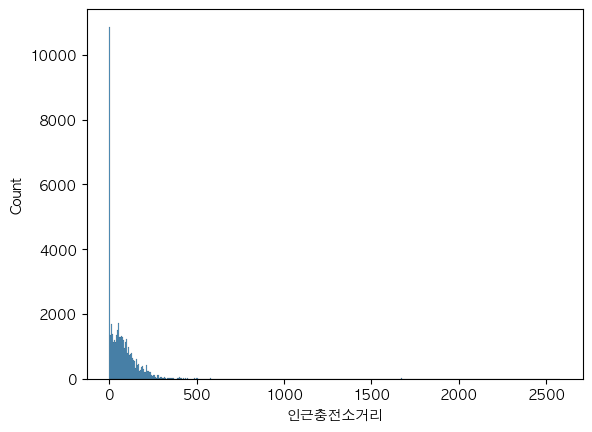

In [170]:
sns.histplot(charger_dong_df2['인근충전소거리'])

- 급속충전소간 최단거리 비교

In [180]:
charger_fast_df = charger_dong_df[charger_dong_df['기종(대)'] == '급속'].reset_index(drop = True)
charger_fast_df.head(3)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,이용자제한,충전기ID,충전소ID,위도,경도,법정동코드,법정동명,중심위도,중심경도,충전소중심지거리
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,이용가능,1,ME174003,37.552909,127.137255,11740107,암사동,37.557805,127.131062,771.170334
1,2017,서울특별시,강동구,서울특별시 강동구 선사로 70,천호유수지 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,이용가능,1,ME174004,37.544812,127.121840,11740109,천호동,37.544376,127.127631,514.128978
2,2017,서울특별시,강동구,서울특별시 강동구 진황도로29길 34,천호3동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,이용가능,1,ME174005,37.538795,127.133399,11740109,천호동,37.544376,127.127631,802.154913


In [ ]:
# 충전소 좌표에 대한 중복값을 제거하여 charger_point 생성
charger_point2 = charger_fast_df[['위도', '경도']].drop_duplicates().reset_index(drop=True)

# 인근충전소위도, 인근충전소경도 컬럼을 charger_point에 추가하고 초기화
charger_point2['인근충전소위도'] = None
charger_point2['인근충전소경도'] = None

# NearestNeighbors 모델을 사용하여 가장 가까운 인근 충전소 찾기
X = charger_point2[['위도', '경도']]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)

# 가장 가까운 인근 충전소 찾아서 인근충전소위도, 인근충전소경도 컬럼에 할당
def find_nearest_neighbor(row):
    # 현재 충전소의 좌표를 제외한 가장 가까운 이웃의 인덱스 찾기
    distances, indices = nbrs.kneighbors([row[['위도', '경도']]])
    nearest_index = indices[0][1]  # 자기 자신을 제외한 가장 가까운 이웃의 인덱스
    nearest_row = charger_point2.iloc[nearest_index]
    # 자기 자신과 동일한 좌표를 가진 행이 있으면 두 번째로 가까운 이웃 선택
    while (nearest_row['위도'] == row['위도']) and (nearest_row['경도'] == row['경도']):
        nearest_index = (nearest_index + 1) % len(charger_point2)  # 인덱스를 순환하도록 수정
        nearest_row = charger_point2.iloc[nearest_index]
    row['인근충전소위도'] = nearest_row['위도']
    row['인근충전소경도'] = nearest_row['경도']
    return row

# 충전소 좌표별로 가장 가까운 인근 충전소를 찾아서 인근충전소위도, 인근충전소경도 컬럼에 할당
charger_fast_df[['인근충전소위도(급속)', '인근충전소경도(급속)']] = charger_fast_df[['위도', '경도']].apply(find_nearest_neighbor, axis=1)[['인근충전소위도', '인근충전소경도']]


In [182]:
#인근 충전소와의 거리 계산

# 위도와 경도 간의 직선 거리를 계산하는 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반지름 (단위: km)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c * 1000  # 미터 단위로 변환
    return distance

# 위도와 경도 간의 직선 거리를 계산하여 인근충전소거리 컬럼에 추가
charger_fast_df['인근충전소거리(급속)'] = charger_fast_df.apply(lambda row: haversine(row['위도'], row['경도'], row['인근충전소위도(급속)'], row['인근충전소경도(급속)']), axis=1)


In [184]:
charger_fast_df.head(3)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,위도,경도,법정동코드,법정동명,중심위도,중심경도,충전소중심지거리,인근충전소위도(급속),인근충전소경도(급속),인근충전소거리(급속)
0,2017,서울특별시,강동구,서울특별시 강동구 고덕로28길 36,암사1동 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,37.552909,127.137255,11740107,암사동,37.557805,127.131062,771.170334,37.552708,127.137997,69.126698
1,2017,서울특별시,강동구,서울특별시 강동구 선사로 70,천호유수지 공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,37.544812,127.121840,11740109,천호동,37.544376,127.127631,514.128978,37.544789,127.121878,4.227212
2,2017,서울특별시,강동구,서울특별시 강동구 진황도로29길 34,천호3동 제1공영주차장,주차시설,공영주차장,급속,급속(50kW),환경부,...,37.538795,127.133399,11740109,천호동,37.544376,127.127631,802.154913,37.539128,127.133269,38.707182


In [185]:
charger_fast_df.describe()

,설치년도,충전기ID,위도,경도,중심위도,중심경도,충전소중심지거리,인근충전소위도(급속),인근충전소경도(급속),인근충전소거리(급속)
count,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000
mean,2021.141465,5.008166,37.546865,126.989001,37.547022,126.989538,750.011416,37.546859,126.989006,207.666342
std,2.115570,8.149731,0.056459,0.089417,0.057307,0.088601,533.232947,0.056399,0.089530,189.547497
min,2012.000000,1.000000,37.437267,126.794854,37.443321,126.787803,16.194342,37.440299,126.798010,0.002086
25%,2020.000000,1.000000,37.499815,126.910722,37.499190,126.912195,363.881522,37.499973,126.911050,67.958622
50%,2022.000000,2.000000,37.540000,126.999802,37.540686,126.997669,659.841290,37.539938,126.996900,160.239566
75%,2023.000000,5.000000,37.584056,127.056149,37.583880,127.056636,996.160532,37.584027,127.056387,300.066797
max,2023.000000,91.000000,37.691550,127.179995,37.684849,127.173384,3684.618712,37.690000,127.178803,1795.514179


<Axes: xlabel='인근충전소거리(급속)', ylabel='Count'>

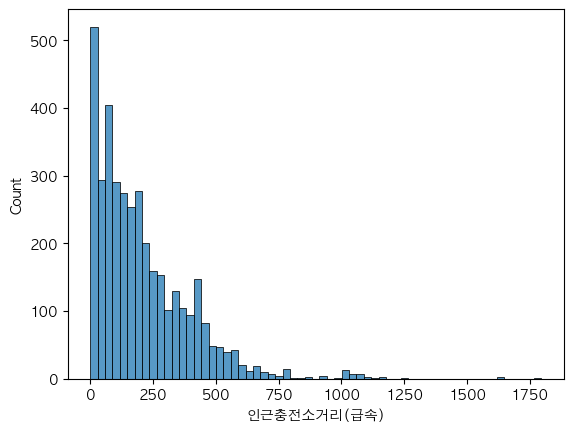

In [186]:
sns.histplot(charger_fast_df['인근충전소거리(급속)'])

- 완속충전소간 최단거리 비교

In [193]:
charger_standard_df = charger_dong_df[charger_dong_df['기종(대)'] == '완속'].reset_index(drop = True)
charger_standard_df.head(3)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,이용자제한,충전기ID,충전소ID,위도,경도,법정동코드,법정동명,중심위도,중심경도,충전소중심지거리
0,2022,서울특별시,용산구,서울특별시 용산구 이태원로 29,용산 전쟁기념관(메가스테이션) 지하 주차장,교육문화시설,관람장,완속,완속(30kW단독),환경부,...,이용가능,1,ME22M302,37.5355,126.9772,11170106,용산동1가,37.540012,126.977027,501.014201
1,2022,서울특별시,용산구,서울특별시 용산구 이태원로 29,용산 전쟁기념관(메가스테이션) 지하 주차장,교육문화시설,관람장,완속,완속(30kW단독),환경부,...,이용가능,2,ME22M302,37.5355,126.9772,11170106,용산동1가,37.540012,126.977027,501.014201
2,2022,서울특별시,용산구,서울특별시 용산구 이태원로 29,용산 전쟁기념관(메가스테이션) 지하 주차장,교육문화시설,관람장,완속,완속(30kW단독),환경부,...,이용가능,3,ME22M302,37.5355,126.9772,11170106,용산동1가,37.540012,126.977027,501.014201


In [ ]:
# 충전소 좌표에 대한 중복값을 제거하여 charger_point 생성
charger_point3 = charger_standard_df[['위도', '경도']].drop_duplicates().reset_index(drop=True)

# 인근충전소위도, 인근충전소경도 컬럼을 charger_point에 추가하고 초기화
charger_point3['인근충전소위도'] = None
charger_point3['인근충전소경도'] = None

# NearestNeighbors 모델을 사용하여 가장 가까운 인근 충전소 찾기
X = charger_point3[['위도', '경도']]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)

# 가장 가까운 인근 충전소 찾아서 인근충전소위도, 인근충전소경도 컬럼에 할당
def find_nearest_neighbor(row):
    # 현재 충전소의 좌표를 제외한 가장 가까운 이웃의 인덱스 찾기
    distances, indices = nbrs.kneighbors([row[['위도', '경도']]])
    nearest_index = indices[0][1]  # 자기 자신을 제외한 가장 가까운 이웃의 인덱스
    nearest_row = charger_point3.iloc[nearest_index]
    # 자기 자신과 동일한 좌표를 가진 행이 있으면 두 번째로 가까운 이웃 선택
    while (nearest_row['위도'] == row['위도']) and (nearest_row['경도'] == row['경도']):
        nearest_index = (nearest_index + 1) % len(charger_point3)  # 인덱스를 순환하도록 수정
        nearest_row = charger_point3.iloc[nearest_index]
    row['인근충전소위도'] = nearest_row['위도']
    row['인근충전소경도'] = nearest_row['경도']
    return row

# 충전소 좌표별로 가장 가까운 인근 충전소를 찾아서 인근충전소위도, 인근충전소경도 컬럼에 할당
charger_standard_df[['인근충전소위도(완속)', '인근충전소경도(완속)']] = charger_standard_df[['위도', '경도']].apply(find_nearest_neighbor, axis=1)[['인근충전소위도', '인근충전소경도']]


In [195]:
# 위도와 경도 간의 직선 거리를 계산하는 함수
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반지름 (단위: km)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c * 1000  # 미터 단위로 변환
    return distance

# 위도와 경도 간의 직선 거리를 계산하여 인근충전소거리 컬럼에 추가
charger_standard_df['인근충전소거리(완속)'] = charger_standard_df.apply(lambda row: haversine(row['위도'], row['경도'], row['인근충전소위도(완속)'], row['인근충전소경도(완속)']), axis=1)


In [196]:
charger_standard_df.head(3)

,설치년도,시도,군구,주소,충전소명,시설구분(대),시설구분(소),기종(대),기종(소),운영기관(대),...,위도,경도,법정동코드,법정동명,중심위도,중심경도,충전소중심지거리,인근충전소위도(완속),인근충전소경도(완속),인근충전소거리(완속)
0,2022,서울특별시,용산구,서울특별시 용산구 이태원로 29,용산 전쟁기념관(메가스테이션) 지하 주차장,교육문화시설,관람장,완속,완속(30kW단독),환경부,...,37.5355,126.9772,11170106,용산동1가,37.540012,126.977027,501.014201,37.537314,126.978466,230.542896
1,2022,서울특별시,용산구,서울특별시 용산구 이태원로 29,용산 전쟁기념관(메가스테이션) 지하 주차장,교육문화시설,관람장,완속,완속(30kW단독),환경부,...,37.5355,126.9772,11170106,용산동1가,37.540012,126.977027,501.014201,37.537314,126.978466,230.542896
2,2022,서울특별시,용산구,서울특별시 용산구 이태원로 29,용산 전쟁기념관(메가스테이션) 지하 주차장,교육문화시설,관람장,완속,완속(30kW단독),환경부,...,37.5355,126.9772,11170106,용산동1가,37.540012,126.977027,501.014201,37.537314,126.978466,230.542896


In [197]:
charger_standard_df.describe()

,설치년도,충전기ID,위도,경도,중심위도,중심경도,충전소중심지거리,인근충전소위도(완속),인근충전소경도(완속),인근충전소거리(완속)
count,41569.000000,41569.000000,41569.000000,41569.000000,41569.000000,41569.000000,41569.000000,41569.000000,41569.000000,41569.000000
mean,2021.490967,10.983449,37.546021,126.992991,37.546217,126.992899,705.054343,37.546016,126.992984,78.517650
std,1.441181,15.426184,0.051265,0.088261,0.051693,0.087657,459.074375,0.051231,0.088228,88.849447
min,2012.000000,0.000000,37.435632,126.768266,37.443321,126.784774,1.736413,37.446271,126.795233,0.000044
25%,2021.000000,2.000000,37.502984,126.919399,37.500078,126.923125,351.197094,37.502984,126.919399,7.924401
50%,2022.000000,4.000000,37.544605,127.012584,37.543610,127.012449,629.927077,37.544884,127.012779,58.499370
75%,2022.000000,13.000000,37.577344,127.057610,37.575895,127.056741,969.033937,37.576740,127.057683,115.119337
max,2023.000000,99.000000,37.691550,127.180837,37.684849,127.173384,3520.828915,37.691550,127.179224,2580.684422


<Axes: xlabel='인근충전소거리(완속)', ylabel='Count'>

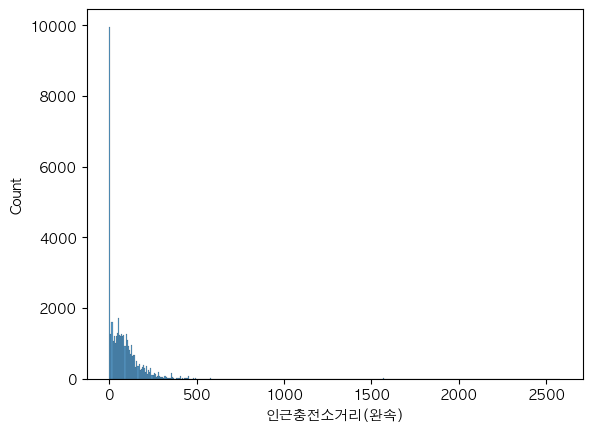

In [200]:
sns.histplot(charger_standard_df['인근충전소거리(완속)'])

- csv 파일 저장 

In [201]:
charger_dong_df2.columns

Index(['설치년도', '시도', '군구', '주소', '충전소명', '시설구분(대)', '시설구분(소)', '기종(대)',
       '기종(소)', '운영기관(대)', '운영기관(소)', '급속충전량', '충전기타입', '이용자제한', '충전기ID',
       '충전소ID', '위도', '경도', '법정동코드', '법정동명', '중심위도', '중심경도', '충전소중심지거리',
       '인근충전소위도', '인근충전소경도', '인근충전소거리'],
      dtype='object')

In [202]:
#불필요한 컬럼 삭제
charger_dong_df2 = charger_dong_df2.drop(columns = ['시도', '운영기관(대)', '운영기관(소)', '급속충전량', '충전기타입', '이용자제한'])
charger_fast_df = charger_fast_df.drop(columns = ['시도', '운영기관(대)', '운영기관(소)', '급속충전량', '충전기타입', '이용자제한'])
charger_standard_df = charger_standard_df.drop(columns = ['시도', '운영기관(대)', '운영기관(소)', '급속충전량', '충전기타입', '이용자제한'])
                                         

In [205]:
charger_dong_df2.to_csv('전처리_충전소_충전소거리추가.csv', index = False)
charger_fast_df.to_csv('전처리_충전소_충전소거리추가(급속).csv', index = False)
charger_standard_df.to_csv('전처리_충전소_충전소거리추가(완속).csv', index = False)